In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.fftpack as fft
from tqdm import tqdm
%matplotlib inline

### Load data

In [2]:
def load_data(data_dir, filename):
    # assign columns label
    columns = ['unix_time', 'n_samples', 'time_period', 'sampling_rate', 'sensor_data']
    df = pd.read_csv(os.path.join(data_dir, filename), 
                     header=None, sep=';', names=columns, nrows=1000)
    
    print('Data have been loaded as dataframe!')
    return df

data_dir = os.getcwd() + '/DataSet' 
filename = 'project_pump.csv'
df_pump = load_data(data_dir, filename)

Data have been loaded as dataframe!


In [3]:
df_pump.head()

,unix_time,n_samples,time_period,sampling_rate,sensor_data
0,1.556892e+09,16384,340,48188.235294,"[1618.377685546875, 1620.2911376953125, 1620.1..."
1,1.556892e+09,16384,340,48188.235294,"[1618.3273315429688, 1620.0393676757812, 1620...."
2,1.556892e+09,16384,341,48046.920821,"[1619.78759765625, 1620.4925537109373, 1620.03..."
3,1.556892e+09,16384,340,48188.235294,"[1619.5358276367188, 1619.586181640625, 1619.9..."
4,1.556892e+09,16384,340,48188.235294,"[1619.1329956054688, 1619.8883056640625, 1619...."


### Reformat data structure

In [4]:
def refactor_data(df):
    # refactor data format 
    print('Refactoring sensor data fomat ...')
    data = df['sensor_data'].values
    data = [item[:-1] for item in tqdm(data)]
    # unit to Volt
    data = [float(val[1:])/1000 for item in tqdm(data) for val in item.split(',')]
    data = np.array(data).reshape(len(df), -1)
    # generate data identification number
    data_id = ['Id' + str(i).zfill(4) for i in tqdm(range(1, len(df)+1))]
    df['data_id'] = data_id
    # generate time serie
    time = np.arange(0, 341, 341/16384)
    # collect sensor data to dataframe
    data_dict = {data_id[i]:data[i] for i in range(len(df))}
    df_data = pd.DataFrame(data_dict)
    df_data['time'] = time
    df_data = df_data.set_index('time')
    # convert unix_time to actual datetime
    df['record_time'] = pd.to_datetime(df['unix_time'], unit='s')
    df = df.drop(columns=['unix_time', 'sensor_data'])
    
    return df, df_data

df_pump, df_data = refactor_data(df_pump)

  2%|▏         | 17/882 [00:00<00:05, 167.48it/s]

Refactoring sensor data fomat ...


100%|██████████| 882/882 [00:00<00:00, 1831374.32it/s]


In [5]:
df_data.head()

,Id0001,Id0002,Id0003,Id0004,Id0005,Id0006,Id0007,Id0008,Id0009,Id0010,...,Id0873,Id0874,Id0875,Id0876,Id0877,Id0878,Id0879,Id0880,Id0881,Id0882
time,,,,,,,,,,,,,,,,,,,,,
0.000000,1.618378,1.618327,1.619788,1.619536,1.619133,1.618277,1.619536,1.619183,1.619637,1.617824,...,1.585547,1.639677,1.610925,1.618277,1.624974,1.619788,1.593855,1.641943,1.614098,1.595970
0.020813,1.620291,1.620039,1.620493,1.619586,1.619888,1.620543,1.619485,1.620039,1.626031,1.619637,...,1.590028,1.639627,1.614601,1.620140,1.626485,1.623917,1.595869,1.643504,1.610925,1.598639
0.041626,1.620190,1.620291,1.620039,1.619939,1.619687,1.620493,1.619687,1.622003,1.620442,1.620039,...,1.596021,1.638469,1.612083,1.620392,1.625024,1.622658,1.596675,1.648288,1.609515,1.595920
0.062439,1.619939,1.618831,1.620190,1.624521,1.619888,1.621147,1.619788,1.619385,1.620744,1.620341,...,1.590431,1.638268,1.613544,1.619536,1.626787,1.623715,1.598085,1.640231,1.613997,1.599344
0.083252,1.620392,1.620341,1.619888,1.619888,1.620392,1.620392,1.620241,1.620593,1.620341,1.620190,...,1.587511,1.640382,1.613493,1.618579,1.625075,1.625427,1.595517,1.646576,1.610522,1.602969


In [16]:
df_pump.head()

,n_samples,time_period,sampling_rate,data_id,record_time,cluster_label
0,16384,340,48188.235294,Id0001,2019-05-03 13:51:43.326399088,0
1,16384,340,48188.235294,Id0002,2019-05-03 13:51:43.710902929,0
2,16384,341,48046.920821,Id0003,2019-05-03 13:51:44.096714020,0
3,16384,340,48188.235294,Id0004,2019-05-03 13:51:44.478333950,0
4,16384,340,48188.235294,Id0005,2019-05-03 13:51:44.870509863,0


### Fast Fourier transformation

In [19]:
def fft_data(df):
    N = len(df)
    sample_space = 341e-3/16384 # sec
    # Hz
    x = np.fft.fftfreq(N, sample_space)[1:N//2]
    # fft
    df_fft = pd.DataFrame()
    df_fft['freq'] = x
    df_fft = df_fft.set_index('freq')
    for idx in tqdm(df.columns):
        # positive only
        f = np.fft.fft(df[idx])
        fft_values = 2 * np.abs(f[1:N//2])
        df_fft[idx] = fft_values

df_fft = fft_data(df_data)

100%|██████████| 882/882 [00:00<00:00, 1223.51it/s]


### K-means clustering

In [8]:
# Clustering with K-means
from sklearn.cluster import KMeans
# Set freqency threshold as 2000 Hz
pos = np.where(x >2000)[0][0]
df_fft_model = df_fft.iloc[:pos]
kmeans = KMeans(n_clusters=2, random_state=42, n_init=100).fit(df_fft_model.T)
# add cluster_label to df_pump
df_pump['cluster_label'] = kmeans.labels_

In [9]:
df_pump.groupby('cluster_label').count()

,n_samples,time_period,sampling_rate,data_id,record_time
cluster_label,,,,,
0,504,504,504,504,504
1,378,378,378,378,378


### Analysis

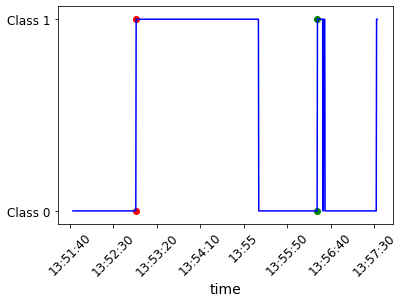

In [31]:
plt.plot(df_pump['record_time'].dt.time, df_pump['cluster_label'], c='b')
plt.xticks(rotation=45, fontsize=12)
plt.yticks([0.0, 1.0], ['Class 0', 'Class 1'],fontsize=12)
plt.xlabel('time', fontsize=14)
plt.scatter([df_pump['record_time'].dt.time[183],df_pump['record_time'].dt.time[184]], [0, 1], 
            c='r')
plt.scatter([df_pump['record_time'].dt.time[708],df_pump['record_time'].dt.time[709]], [0, 1], 
            c='g')
plt.show()

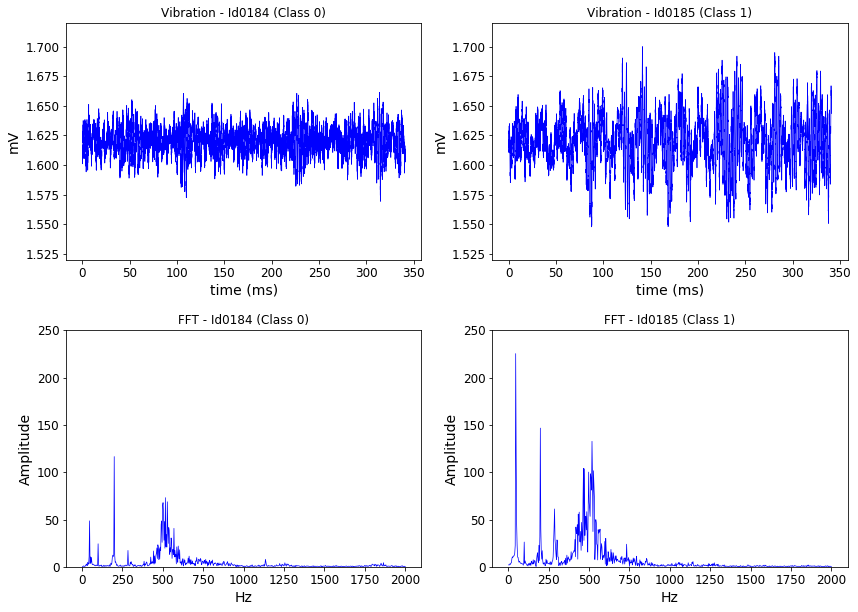

In [17]:
def make_subplots(data, loc_index, title, x_label, y_label, y_lim):
    ax[loc_index].plot(data, c='b', linewidth=0.7)
    ax[loc_index].title.set_text(title)
    ax[loc_index].set_ylim(y_lim)
    ax[loc_index].set_xlabel(x_label, fontsize=14)
    ax[loc_index].set_ylabel(y_label, fontsize=14)
    ax[loc_index].tick_params(labelsize=12)

fig, ax = plt.subplots(2, 2, figsize=(14, 10))
plt.subplots_adjust(hspace=0.3)
# subplot 1
make_subplots(df_data['Id0184'], (0,0), 
              title='Vibration - Id0184 (Class 0)',
              x_label='time (ms)', y_label = 'mV',
              y_lim=[1.52, 1.72])
# subplot 2
make_subplots(df_data['Id0185'], (0,1), 
              title='Vibration - Id0185 (Class 1)',
              x_label='time (ms)', y_label = 'mV',
              y_lim=[1.52, 1.72])
# subplot 3
make_subplots(df_fft_model['Id0184'], (1,0), 
              title='FFT - Id0184 (Class 0)',
              x_label='Hz', y_label = 'Amplitude',
              y_lim=[0, 250])
# subplot 4
make_subplots(df_fft_model['Id0185'], (1,1), 
              title='FFT - Id0185 (Class 1)',
              x_label='Hz', y_label = 'Amplitude',
              y_lim=[0, 250])

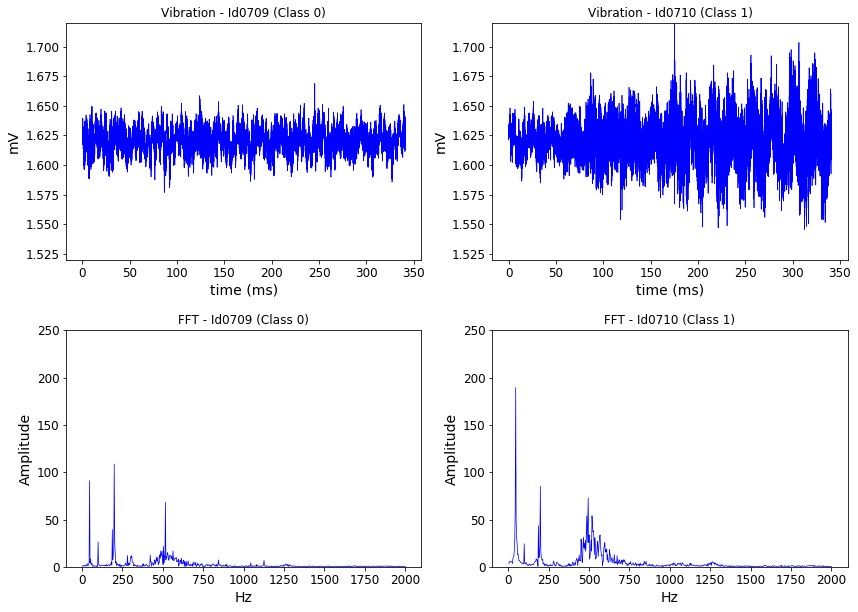

In [26]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))
plt.subplots_adjust(hspace=0.3)
# subplot 1
make_subplots(df_data['Id0709'], (0,0), 
              title='Vibration - Id0709 (Class 0)',
              x_label='time (ms)', y_label = 'mV',
              y_lim=[1.52, 1.72])
# subplot 2
make_subplots(df_data['Id0710'], (0,1), 
              title='Vibration - Id0710 (Class 1)',
              x_label='time (ms)', y_label = 'mV',
              y_lim=[1.52, 1.72])
# subplot 3
make_subplots(df_fft_model['Id0709'], (1,0), 
              title='FFT - Id0709 (Class 0)',
              x_label='Hz', y_label = 'Amplitude',
              y_lim=[0, 250])
# subplot 4
make_subplots(df_fft_model['Id0710'], (1,1), 
              title='FFT - Id0710 (Class 1)',
              x_label='Hz', y_label = 'Amplitude',
              y_lim=[0, 250])